In [1]:
#imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [2]:
%run dataloader.ipynb

train size:  7614
dev size:  980
test size:  994


In [3]:
batch_size=500
train_dataloader = DataLoader(train_set, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_set, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)

In [4]:
gpu_id = 'cuda:5'
device = torch.device(gpu_id if torch.cuda.is_available() else 'cpu')

In [5]:
# cnn
class CNN(torch.nn.Module):

    def __init__(self, hidden_layer_size_1, window_size_1, hidden_layer_size_2) -> None:
        super().__init__()
        self.window_size_1 = window_size_1
        self.w1 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (hidden_layer_size_1, 300, window_size_1)), dtype=torch.float32))
        self.b1 = torch.nn.Parameter(torch.zeros((hidden_layer_size_1,), dtype=torch.float32))
        self.w2 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (hidden_layer_size_1, hidden_layer_size_2)), dtype=torch.float32))
        self.b2 = torch.nn.Parameter(torch.zeros((hidden_layer_size_2,), dtype=torch.float32))
        self.w3 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (hidden_layer_size_2, 1)), dtype=torch.float32))
        self.b3 = torch.nn.Parameter(torch.zeros((1,), dtype=torch.float32))

    def forward(self, x, text_lens):
        x_t = x.transpose(1, 2)
        hidden_1_t = torch.nn.functional.leaky_relu(torch.nn.functional.conv1d(x_t, self.w1, self.b1))
        hidden = hidden_1_t.transpose(1, 2)

        pad_mask = torch.zeros(hidden.shape, dtype=torch.bool, device=device)
        for i in range(hidden.shape[0]):
            for j in range(hidden.shape[1]):
                pad_mask[i, j, :] = j >= (text_lens[i] - self.window_size_1 + 1)
        masked = torch.masked_fill(hidden, pad_mask, torch.tensor(np.inf))
        
        pooled = torch.min(masked, dim=1)[0]

        hidden_2 = torch.nn.functional.leaky_relu(pooled@self.w2 + self.b2)
        return hidden_2@self.w3 + self.b3

step error


/tmp/ipykernel_2594019/324524730.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_2594019/324524730.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_2594019/324524730.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you mea

1 82.52680206298828
dev accuracy: 50.26%
2 90.740966796875
dev accuracy: 50.46%
3 75.24849700927734
dev accuracy: 51.50%
4 71.975341796875
dev accuracy: 50.98%
5 52.96861267089844
dev accuracy: 50.88%
6 61.494232177734375
dev accuracy: 50.77%
7 97.65190887451172
dev accuracy: 51.60%
8 87.52603912353516
dev accuracy: 51.70%
9 73.56387329101562
dev accuracy: 52.01%
10 73.6676254272461
dev accuracy: 52.01%
11 59.200035095214844
dev accuracy: 52.12%
12 66.54363250732422
dev accuracy: 52.43%
13 53.367000579833984
dev accuracy: 52.53%
14 58.39440155029297
dev accuracy: 52.73%
15 49.596920013427734
dev accuracy: 53.04%
16 43.9985466003418
dev accuracy: 52.84%
17 54.35954666137695
dev accuracy: 53.15%
18 38.414398193359375
dev accuracy: 52.94%
19 49.356590270996094
dev accuracy: 53.15%
20 29.200817108154297
dev accuracy: 53.04%


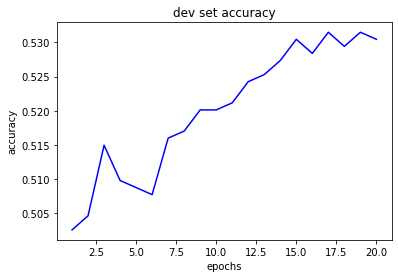

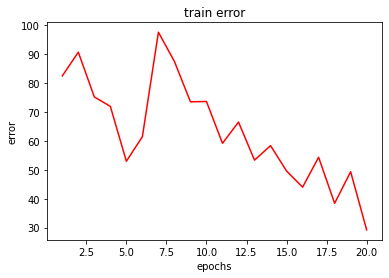

In [9]:
device = torch.device(gpu_id if torch.cuda.is_available() else 'cpu')
cnn = CNN(hidden_layer_size_1=512, window_size_1=2, hidden_layer_size_2=512)
cnn.to(device)

optimiser = torch.optim.Adam(cnn.parameters(), lr=0.0001)
epochs = 20

print('step', 'error')
dev_accs = []
errors = []
for epoch in range(1, epochs+1):
    for batch_idx, batch in enumerate(train_dataloader, 0):
        x_p,x_c,y,hid,x_p_len=map(lambda x: x.to(device), batch)
        optimiser.zero_grad()
        output = cnn(x_p[:, :, :300], x_p_len)
        error = torch.nn.functional.binary_cross_entropy_with_logits(output, y)
        error.backward()
        optimiser.step()
    
    print(epoch, error.detach().tolist())
    errors.append(error.detach().tolist())

    with torch.no_grad():
        matches = 0
        total = 0
        for batch_idx, batch in enumerate(dev_dataloader, 0): 
            x_p,x_c,y,hid,x_p_len=map(lambda x: x.to(device), batch)
            outputs = torch.sigmoid(cnn(x_p[:, :, :300], x_p_len))
            predictions = (outputs > 0.5)*1
            matches += (y == predictions).sum()
            total += len(y)
        acc = matches / total
        dev_accs.append(float(acc))
        print('dev accuracy: {:.2%}'.format(float(acc)))

plt.plot(range(1, epochs+1), dev_accs, 'b')
plt.title('dev set accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

plt.plot(range(1, epochs+1), errors, 'r')
plt.title('train error')
plt.xlabel('epochs')
plt.ylabel('error')
plt.show()

In [10]:
with torch.no_grad():
    matches = 0
    total = 0
    for batch_idx, batch in enumerate(test_dataloader, 0): 
        x_p,x_c,y,hid,x_p_len=map(lambda x: x.to(device), batch)
        outputs = torch.sigmoid(cnn(x_p[:, :, :300], x_p_len))
        predictions = (outputs > 0.5)*1
        matches += (y == predictions).sum()
        total += len(y)
    acc = matches / total
    print('test accuracy: {:.2%}'.format(float(acc)))

/tmp/ipykernel_2594019/324524730.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_2594019/324524730.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_2594019/324524730.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you mea

test accuracy: 51.43%
